# NIH X-Ray Classification

## Import Data and Split

Import Data_Entry_2017.csv file which has file names and labels for all images.

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

OUTPUT_DIR = '../models/'

In [2]:
df = pd.read_csv('../data/Data_Entry_2017.csv')
df['labels'] = df['Finding Labels'].apply(lambda x: x.split('|'))

In [3]:
print(f'Total number of images {len(df)}')

Total number of images 112120


### Check for infrequent values

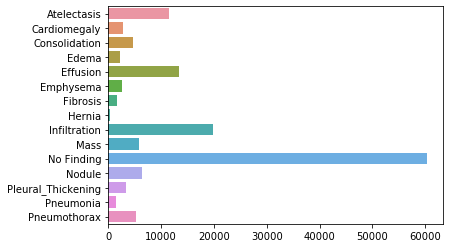

In [4]:
import seaborn as sns

labels = []
for label in df.labels:
    labels += label
    
labels = np.array(labels)
lab, count = np.unique(labels, return_counts=True)

sns.barplot(count, lab, orient='h')

In [5]:
lab[count < 2000]

array(['Fibrosis', 'Hernia', 'Pneumonia'], dtype='<U18')

It looks like hernia, fibrosis and pneumonia are relatively rare so we'll remove them from the dataset

In [6]:
remove = ['No Finding', 'Fibrosis', 'Hernia', 'Pneumonia']
df['labels'] = df['labels'].apply(lambda x: list(filter(lambda a: a not in remove, x)))

df.rename(columns={'Image Index': 'filename', 'Patient ID': 'patient_id'}, inplace=True)
image_df = df[['filename', 'patient_id', 'labels']]
image_df.head(25)

,filename,patient_id,labels
0,00000001_000.png,1,[Cardiomegaly]
1,00000001_001.png,1,"[Cardiomegaly, Emphysema]"
2,00000001_002.png,1,"[Cardiomegaly, Effusion]"
3,00000002_000.png,2,[]
4,00000003_000.png,3,[]
5,00000003_001.png,3,[]
6,00000003_002.png,3,[]
7,00000003_003.png,3,[Infiltration]
8,00000003_004.png,3,[]
9,00000003_005.png,3,[]


### Perform Train/Test Split
Split train/test data based on Patient ID. We want to ensure that there is not overlap in patients between the train and test sets as this would likely cause model testing metrics to appear better than they might actually be.

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
unique_patient_ids = list(image_df.patient_id.unique())
patient_id_train_full, patient_id_test = train_test_split(unique_patient_ids, test_size=0.25, random_state=333)

### Further Break Traing Set into Train/Validate Set

In [9]:
patient_id_train, patient_id_validate = train_test_split(patient_id_train_full, test_size=0.25, random_state=222)

In [10]:
train_df = image_df.query(f'patient_id in {patient_id_train}')
validate_df = image_df.query(f'patient_id in {patient_id_validate}')
test_df = image_df.query(f'patient_id in {patient_id_test}')

In [11]:
print(f'Train:\t\t  {len(train_df)}')
print(f'Validate:\t+ {len(validate_df)}')
print(f'Test:\t\t+ {len(test_df)}')
print(f'Total:\t\t= {len(image_df)}')

Train:		  62248
Validate:	+ 21651
Test:		+ 28221
Total:		= 112120


## Build Image Generators

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# train_image_generator = ImageDataGenerator(rescale=1./255, zoom_range=0.2, width_shift_range=0.1, height_shift_range=0.1, rotation_range=5)
train_image_generator = ImageDataGenerator(rescale=1./255, 
                                           rotation_range=10, 
                                           width_shift_range=20,
                                           height_shift_range=20,
                                           zoom_range=0.2)
validate_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

common_params = {
    'target_size': (244, 244),
    'directory': '../data/images',
    'x_col': 'filename',
    'y_col': 'labels', 
    'color_mode': 'rgb', 
    'class_mode': 'categorical'
}

train_data_gen = train_image_generator.flow_from_dataframe(train_df, **common_params)

validate_data_gen = validate_image_generator.flow_from_dataframe(validate_df, **common_params)

test_data_gen = test_image_generator.flow_from_dataframe(test_df, **common_params)

Found 62248 validated image filenames belonging to 11 classes.
Found 21651 validated image filenames belonging to 11 classes.
Found 28221 validated image filenames belonging to 11 classes.


### Visualize Images

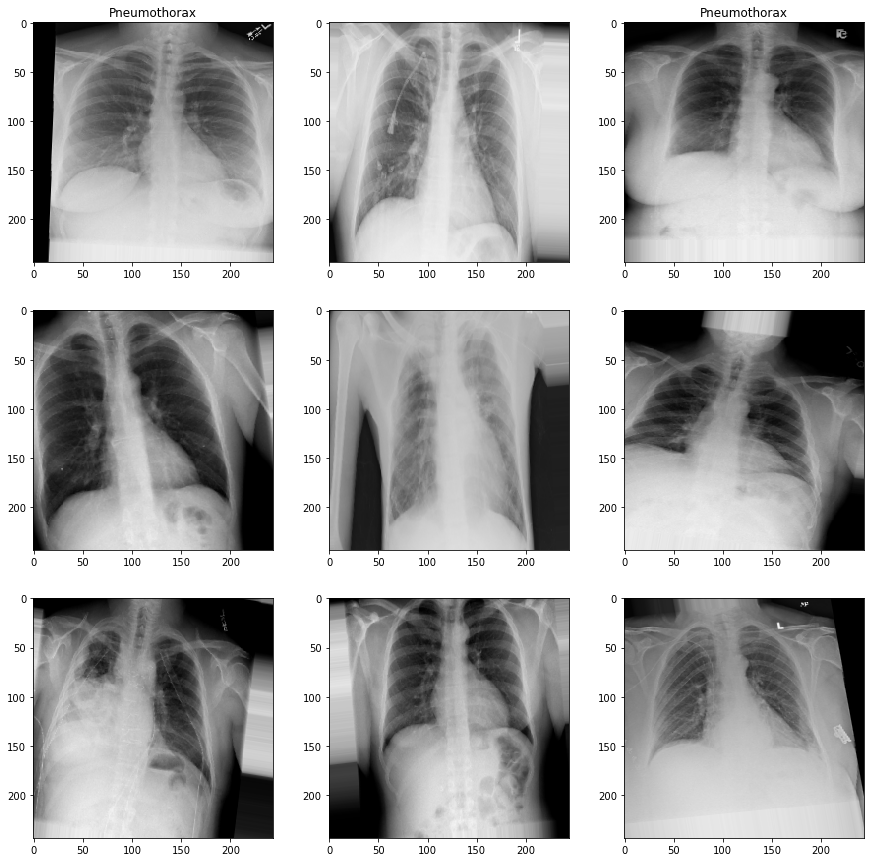

In [13]:
import matplotlib.pyplot as plt

CLASS_NAMES = np.array(list(train_data_gen.class_indices.keys()))

image_batch, label_batch = next(train_data_gen)

plt.figure(figsize=(15,15))
for n in range(9):
    plt.subplot(3,3,n+1)
    plt.imshow(image_batch[n])
    plt.title(' | '.join(CLASS_NAMES[label_batch[n]==1]))

# plt.savefig('example.png')

## Build Models

In [14]:
import datetime
from pathlib import Path

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.optimizers import Adam

base_log_dir = Path("logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
scratch_log_dir= base_log_dir / 'scratch'
trans_log_dir= base_log_dir / 'trans'
trans2_log_dir= base_log_dir / 'trans'
scratch_log_dir.mkdir(parents=True, exist_ok=True)
trans_log_dir.mkdir(parents=True, exist_ok=True)
trans2_log_dir.mkdir(parents=True, exist_ok=True)
scratch_tensorboard_callback = TensorBoard(log_dir=str(scratch_log_dir), histogram_freq=1, profile_batch = 100000000)
trans_tensorboard_callback = TensorBoard(log_dir=str(trans_log_dir), histogram_freq=1, profile_batch = 100000000)
trans2_tensorboard_callback = TensorBoard(log_dir=str(trans2_log_dir), histogram_freq=1, profile_batch = 100000000)

### From Scratch

In [ ]:
x_ray_scratch_clf = models.Sequential([    
    layers.Conv2D(32, (3,3), activation='relu', input_shape=train_data_gen.image_shape),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(256, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(512, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(len(CLASS_NAMES), activation='sigmoid')
])

x_ray_scratch_clf.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

x_ray_scratch_clf.summary()

In [ ]:
output_file = OUTPUT_DIR + 'x_ray_scratch_clf_v3.h5'

x_ray_scratch_clf.fit(
    train_data_gen,
    epochs=30,
    steps_per_epoch=100,
    validation_data=validate_data_gen,
    validation_steps=50,
    callbacks=[
        EarlyStopping(verbose=1, patience=3),
        ModelCheckpoint(output_file, save_best_only=True),
        scratch_tensorboard_callback
    ]
)

### Transfer Learning

#### MobileNet Base

In [ ]:
x_ray_mobilenet_clf = models.Sequential([
    MobileNet(input_shape=train_data_gen.image_shape, weights='imagenet', include_top = False),
    
    layers.Dropout(0.4),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(len(CLASS_NAMES), activation='sigmoid')
])

opt = Adam(learning_rate=0.00001)
x_ray_mobilenet_clf.compile(loss='binary_crossentropy', optimizer=opt, metrics=['acc'])

x_ray_mobilenet_clf.summary()

In [ ]:
output_file = OUTPUT_DIR + 'x_ray_mobilenet_clf_v1.h5'

x_ray_mobilenet_clf.fit(
    train_data_gen,
    epochs=50,
    steps_per_epoch=100,
    validation_data=validate_data_gen,
    validation_steps=50,
    callbacks=[
        EarlyStopping(verbose=1, patience=3),
        ModelCheckpoint(output_file, save_best_only=True),
        trans_tensorboard_callback
    ]
)

### VGG19 Base

In [15]:
x_ray_vgg19_clf = models.Sequential([
    VGG19(input_shape=train_data_gen.image_shape, weights='imagenet', include_top = False),
    
    layers.Dropout(0.4),
    
    layers.Flatten(),
    layers.Dense(4096, activation='relu'),
    layers.Dense(1000, activation='relu'),
    layers.Dense(len(CLASS_NAMES), activation='sigmoid')
])

opt = Adam(learning_rate=0.0000001)
x_ray_vgg19_clf.compile(loss='binary_crossentropy', optimizer=opt, metrics=['acc'])

x_ray_vgg19_clf.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 4096)              102764544 
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              4097000   
_________________________________________________________________
dense_2 (Dense)              (None, 11)                11011     
Total params: 126,896,939
Trainable params: 126,896,939
Non-trainable params: 0
__________________________________________

In [16]:
from tensorflow.keras.models import load_model
output_file = OUTPUT_DIR + 'x_ray_vgg19_clf_v4.h5'

# x_ray_vgg19_clf = load_model(output_file)

x_ray_vgg19_clf.fit(
    train_data_gen,
    epochs=100,
    steps_per_epoch=100,
    validation_data=validate_data_gen,
    validation_steps=50,
    callbacks=[
        EarlyStopping(verbose=1, patience=3),
        ModelCheckpoint(output_file, save_best_only=True),
        trans2_tensorboard_callback
    ]
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 50 steps
Epoch 1/100
100/100 [==============================] - 148s 1s/step - loss: 0.6603 - acc: 0.6274 - val_loss: 0.5153 - val_acc: 0.7890
Epoch 2/100
100/100 [==============================] - 132s 1s/step - loss: 0.5120 - acc: 0.7917 - val_loss: 0.3901 - val_acc: 0.9411
Epoch 3/100
100/100 [==============================] - 132s 1s/step - loss: 0.3941 - acc: 0.9055 - val_loss: 0.3025 - val_acc: 0.9415
Epoch 4/100
100/100 [==============================] - 133s 1s/step - loss: 0.3152 - acc: 0.9321 - val_loss: 0.2505 - val_acc: 0.9415
Epoch 5/100
100/100 [==============================] - 134s 1s/step - loss: 0.2681 - acc: 0.9372 - val_loss: 0.2242 - val_acc: 0.9415
Epoch 6/100
100/100 [==============================] - 133s 1s/step - loss: 0.2492 - acc: 0.9352 - val_loss: 0.2126 - val_acc: 0.9415
Epoch 7/100
100/100 [==============================] - 130s 1s/step - loss: 0.2349 - acc: 0.9369 - val_

KeyboardInterrupt: 

### Test the model
#### Load Model

In [17]:
from tensorflow.keras.models import load_model

clf = load_model('../models/x_ray_vgg19_clf_v4.h5')

#### Load Image

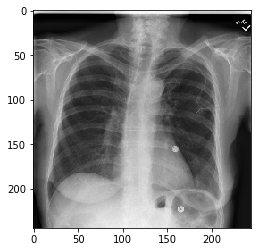

In [18]:
import numpy as np
from tensorflow.keras.preprocessing import image

image_path = './ex3.png'

img = image.load_img(image_path, target_size=(244,244))

img_array = np.array(img) * (1./255)

plt.imshow(img_array)

#### Classify Image

In [20]:
img_array = img_array.reshape((1,244,244,3))

pred = clf.predict_classes(img_array)

CLASS_NAMES[pred]

array(['Infiltration'], dtype='<U18')

In [ ]:
from vis.visualization import visualize_cam, visualize_cam_with_losses

visualize_cam(clf, 1, seed_input=img_array)

In [1]:
from pathlib import Path

In [5]:
list(Path('.').glob('*.png'))

[WindowsPath('ex1_cardiomegaly_emphysema.png'),
 WindowsPath('ex3.png'),
 WindowsPath('example.png'),
 WindowsPath('ex_mass_nodule.png')]